In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

from tensorflow import keras
from keras.layers import SimpleRNN, Dense, Input, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential, Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

In [2]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

In [31]:
print(f"train_images: {train_images.shape}")
print(f"train_labels: {train_labels.shape}")

print(f"test__images: {test_images.shape}")
print(f"test_labels: {test_labels.shape}")

train_images: (60000, 28, 28)
train_labels: (60000,)
test__images: (10000, 28, 28)
test_labels: (10000,)


In [4]:
def norm(data):
  max_value = data.max()
  min_value = data.min()

  return (data - min_value) / (max_value - min_value)

In [5]:
train_images = norm(train_images)
test_images = norm(test_images)

In [34]:
train_labels.min(), train_labels.max()

(0, 9)

## Sequential 사용

In [82]:
def get_regularised_model(input_shape, dropout_rate, weight_decay):

    model = Sequential([
            Flatten(input_shape=input_shape),
            Dense(256, kernel_initializer=tf.keras.initializers.HeNormal(), 
                  bias_initializer=tf.keras.initializers.Constant(value=1),
                  kernel_regularizer=regularizers.l2(weight_decay),
                  activation="relu"),
            Dropout(dropout_rate),
            Dense(128, kernel_regularizer=regularizers.l2(weight_decay), activation="relu"),
            Dense(128, kernel_regularizer=regularizers.l2(weight_decay), activation="relu"),
            BatchNormalization(),
            Dense(64, kernel_regularizer=regularizers.l2(weight_decay), activation="relu"),
            Dense(64, kernel_regularizer=regularizers.l2(weight_decay), activation="relu"),
            Dropout(dropout_rate),
            Dense(32, kernel_regularizer=regularizers.l2(weight_decay), activation="relu"),
            Dense(32, kernel_regularizer=regularizers.l2(weight_decay), activation="relu"),
            Dropout(dropout_rate),
            Dense(10, activation="softmax")
    ])
    
    return model

In [83]:
Sequential_model = get_regularised_model(train_images[0].shape, 0.3, 0.001)
Sequential_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_62 (Dense)            (None, 256)               200960    
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dense_63 (Dense)            (None, 128)               32896     
                                                                 
 dense_64 (Dense)            (None, 128)               16512     
                                                                 
 batch_normalization_7 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                      

In [85]:
Sequential_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ["accuracy"])

In [87]:
Sequential_hist = Sequential_model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=5, verbose=2)

Epoch 1/5
1875/1875 - 12s - loss: 0.4868 - accuracy: 0.9421 - val_loss: 0.4041 - val_accuracy: 0.9555 - 12s/epoch - 6ms/step
Epoch 2/5
1875/1875 - 11s - loss: 0.4824 - accuracy: 0.9416 - val_loss: 0.3957 - val_accuracy: 0.9544 - 11s/epoch - 6ms/step
Epoch 3/5
1875/1875 - 12s - loss: 0.4655 - accuracy: 0.9430 - val_loss: 0.3709 - val_accuracy: 0.9612 - 12s/epoch - 6ms/step
Epoch 4/5
1875/1875 - 11s - loss: 0.4647 - accuracy: 0.9419 - val_loss: 0.3561 - val_accuracy: 0.9627 - 11s/epoch - 6ms/step
Epoch 5/5
1875/1875 - 12s - loss: 0.4548 - accuracy: 0.9425 - val_loss: 0.3635 - val_accuracy: 0.9624 - 12s/epoch - 7ms/step


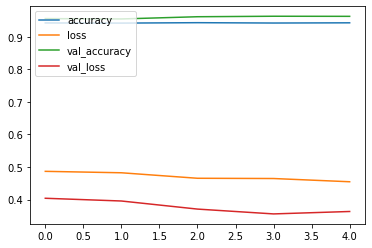

In [88]:
plt.plot(Sequential_hist.history['accuracy'], label='accuracy')
plt.plot(Sequential_hist.history['loss'], label='loss')
plt.plot(Sequential_hist.history['val_accuracy'], label='val_accuracy')
plt.plot(Sequential_hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

In [89]:
res = Sequential_model.predict( test_images[3:4] ) 
res.shape

(1, 10)

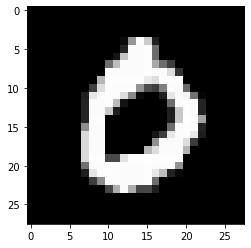

In [90]:
plt.imshow(test_images[3], cmap="gray")
plt.show()

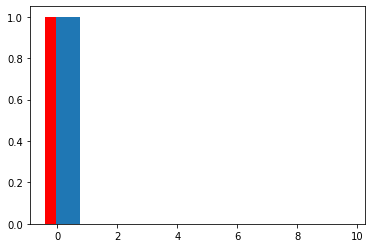

In [91]:
plt.bar(range(10), res[0], color='red')
plt.bar(np.array(range(10)) + 0.35, to_categorical(test_labels[3], 10))
plt.show()

In [92]:
Sequential_model.save("models/DNN_based_MNIST_001.h5")

## Model 사용

In [93]:
def DNN_mnist_model(input_shape, dropout_rate, weight_decay):
    
    inputs = Input(input_shape)
    processed = Flatten()(inputs)
    x = Dense(256, kernel_initializer=tf.keras.initializers.HeNormal(), 
                  bias_initializer=tf.keras.initializers.Constant(value=1),
                  kernel_regularizer=regularizers.l2(weight_decay),
                  activation="relu")(processed)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, kernel_regularizer=regularizers.l2(weight_decay), activation="relu")(x)
    x = Dense(128, kernel_regularizer=regularizers.l2(weight_decay), activation="relu")(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(64, kernel_regularizer=regularizers.l2(weight_decay), activation="relu")(x)
    x = Dense(64, kernel_regularizer=regularizers.l2(weight_decay), activation="relu")(x)
    x = BatchNormalization()(x)

    x = Dense(32, kernel_regularizer=regularizers.l2(weight_decay), activation="relu")(x)
    x = Dense(32, kernel_regularizer=regularizers.l2(weight_decay), activation="relu")(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(10, activation="softmax")(x)

    return Model(inputs, x)

In [94]:
train_images[0].shape

(28, 28)

In [96]:
model = DNN_mnist_model(train_images[0].shape, 0.3, 0.001)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 dense_78 (Dense)            (None, 256)               200960    
                                                                 
 dropout_24 (Dropout)        (None, 256)               0         
                                                                 
 dense_79 (Dense)            (None, 128)               32896     
                                                                 
 dense_80 (Dense)            (None, 128)               16512     
                                                                 
 dropout_25 (Dropout)        (None, 128)               0   

In [113]:
keras.utils.plot_model(model, "my_first_model.png")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [112]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [98]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ["accuracy"])

In [99]:
hist = model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=5, verbose=2)

Epoch 1/5
1875/1875 - 13s - loss: 1.2057 - accuracy: 0.7967 - val_loss: 0.6471 - val_accuracy: 0.9282 - 13s/epoch - 7ms/step
Epoch 2/5
1875/1875 - 13s - loss: 0.6509 - accuracy: 0.9222 - val_loss: 0.4830 - val_accuracy: 0.9498 - 13s/epoch - 7ms/step
Epoch 3/5
1875/1875 - 12s - loss: 0.5548 - accuracy: 0.9324 - val_loss: 0.4254 - val_accuracy: 0.9550 - 12s/epoch - 7ms/step
Epoch 4/5
1875/1875 - 12s - loss: 0.5056 - accuracy: 0.9374 - val_loss: 0.4032 - val_accuracy: 0.9563 - 12s/epoch - 7ms/step
Epoch 5/5
1875/1875 - 16s - loss: 0.4797 - accuracy: 0.9412 - val_loss: 0.4283 - val_accuracy: 0.9452 - 16s/epoch - 8ms/step


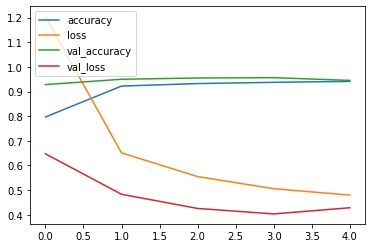

In [100]:
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

In [101]:
res = model.predict( test_images[3:4] ) 
res.shape

(1, 10)

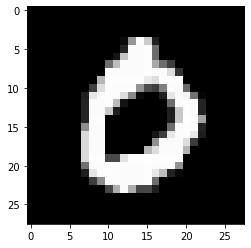

In [102]:
plt.imshow(test_images[3], cmap="gray")
plt.show()

In [103]:
print(res[0])
print(res[0].argmax())
print(res[0].max())

print(test_labels[3])
show = to_categorical( test_labels[3], 10)
print(show)

[9.9651515e-01 5.0604143e-07 1.1704799e-03 2.4344369e-04 3.4926834e-05
 1.0957987e-03 4.9609307e-04 6.9440292e-05 4.9568847e-05 3.2466298e-04]
0
0.99651515
0
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


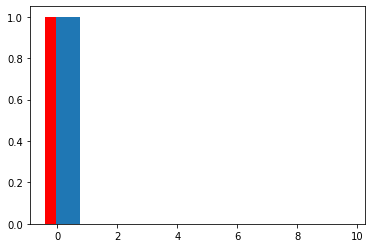

In [104]:
plt.bar(range(10), res[0], color='red')
plt.bar(np.array(range(10)) + 0.35, to_categorical(test_labels[3], 10))
plt.show()

In [105]:
model.save("models/DNN_based_MNIST_002.h5")